# Project 4 

Outline:

* scraping data

* binning: by salary

* parsing data: tokenizing, bigrams, most_common words for each bin 

* building model

* evaluating model


Downloading the whole data for US. 09/29/2016

In [ ]:
df

In [128]:
# check one entry to verify contents
print df.iloc[6]

company                                                             Cisco Systems, Inc.
job_link        http://www.indeed.com/rc/clk?jk=6cb402d057d00c35&fccid=dfc44f3b8c44a6db
job_location                                                               San Jose, CA
job_posted                                                                  Just posted
job_title                                       Data Scientist - Technology and Quality
Name: 6, dtype: object


In [129]:
# Save the result to CSV
df.to_csv('./indeed_companies.csv', encoding='utf-8')

Downloading the whole data for Australia. 09/29/2016

In [130]:
# load the library


df_au = pd.DataFrame()   # create a new data frame
pd.set_option('max_colwidth',500)    # to remove column limit (default is 50. Otherwise, we'll lose some info)


# indeed.com's query url
base_url = 'http://au.indeed.com/jobs?q=Data+Scientist&jt=fulltime'
sort_by = 'date'          # sort by data
start_from = '&start='    # start page number

for page in range(1,10): # page from 1 to 100 
    page = (page-1) * 10   # pagination
    url = "%s%s%s%d" % (base_url, sort_by, start_from, page) # get full url 
    contents = BeautifulSoup(urllib2.urlopen(url), "lxml") 

    contentsElements_au = contents.find_all('div', attrs={"class" : '  row  result'})
    cont_au = contents.find('div', attrs = {'class': 'lastRow  row  result'}) ##just added last job on each page
    contentsElements_au.append(cont_au)
    # each row contains 1 job

    # extract job information
    for elem in contentsElements_au: 
        try:
            company_au = elem.find('span', attrs={'itemprop':'name'}).getText().strip() #strips off whitespace 
        except AttributeError:
            company = '-'
        job_title_au = elem.find('a', attrs={'class':'turnstileLink'}).attrs['title']
        home_url_au = "http://www.indeed.com"
        job_link_au = "%s%s" % (home_url,elem.find('a').get('href'))
        job_addr_au = elem.find('span', attrs={'itemprop':'addressLocality'}).getText()
        job_posted_au = elem.find('span', attrs={'class': 'date'}).getText()

           # add a record of job info to our data frame

        df_au = df_au.append({'company': company_au, 
                        'job_title': job_title_au, 
                        'job_link': job_link_au, 
                        'job_posted': job_posted_au,
                        'job_location': job_addr_au
                       }, ignore_index=True)
df_au

Save the result to CSV
df_au.to_csv('./indeed_companies_au.csv', encoding='utf-8')

jobs_data = pd.read_csv('indeed_companies.csv')
jobs_data_au = pd.read_csv('indeed_companies_au.csv')
frames = [jobs_data, jobs_data_au]
result = pd.concat(frames, axis = 0, ignore_index = True)
result

In [1]:
import matplotlib as plt
%matplotlib inline
import pandas as pd
from bs4 import BeautifulSoup
import urllib2, requests

.

In [3]:
def extract_text(el):
    if el:
        return el.text.strip()
    else:
        return ''      

def get_company_from_result(result):
    return extract_text(result.find('span', {'class' : 'company'}))

def get_location_from_result(result):
    return extract_text(result.find('span', {'class' : 'location'}))

def get_summary_from_result(result):
    return extract_text(result.find('span', {'class' : 'summary'}))

def get_title_from_result(result):
    return result.find('a', {'data-tn-element' : 'jobTitle'}).text.strip()

def get_salary_from_result(result):
    salary_table = result.find('td', {'class' : 'snip'})
    if salary_table:
        snip = salary_table.find('nobr')
        if snip:
            return snip.text.strip()

    return None


def extract_salary_average(salary_string):
    regex = r'\$([0-9]+,[0-9]+)'
    matches = re.findall(regex, salary_string)
    return np.mean([float(salary.replace(',', '')) for salary in matches ])


In [74]:

url_template = "http://www.indeed.com/jobs?q=data+scientist+${}%2C000&l=USA&start={}"
max_results_per_city = 5000 # Set this to a high-value (5000) to generate more results. 

# Crawling more results, will also take much longer. First test your code on a small number of results and then expand.

#city = elem.find('span', attrs={'itemprop':'addressLocality'}).getText()

rows = []
for salary in set([ '55-70', '70-85', '85-100', '100-115']):
    for start in range(1,10): 
        r = requests.get(url_template.format(salary, start))
        soup = BeautifulSoup(r.content) 
        results = soup.findAll('div', { "class" : "result" })
        for result in results:
            if result:
                row = {}
                row['title'] = get_title_from_result(result)
                row['company'] = get_company_from_result(result)
                row['summary'] = get_summary_from_result(result)
                row['city'] = get_location_from_result(result) 
                row['bin'] = salary
            #row['salary'] = get_salary_from_result(result)
                rows.append(row)
                

In [5]:
#result.to_csv('./indeed_companies.csv', encoding='utf-8')

In [75]:
pd.set_option('max_colwidth',500)
result = pd.DataFrame.from_records(rows)
#result.set_option('max_colwidth',500) # create a new data frame
result.drop_duplicates(subset = "summary")

,bin,city,company,summary,title
0,85-100,"Santa Clara Valley, CA",Apple,"We are looking for a highly motivated data scientist proficient in generating meaningful insights from complex, multi-dimensional data that can inform and...",Data Scientist - Fitness & Health
1,85-100,"Santa Clara Valley, CA",Apple,"Use distributed data processing and analysis. 5+ years experience working on data science projects. Attention to detail, data accuracy, and quality of output....",Data Scientist - Maps POI
2,85-100,"Washington, DC",Social Tables,"As Social Tables first Data Scientist, you'll be helping us to double-down on our data-informed culture. Skilled in SQL (and NoSQL experience is a plus) to get...",Data Scientist
3,85-100,"San Bruno, CA 94066",Walmart eCommerce,They assist in building large data sets from multiple sources in order to build algorithms for predicting future data characteristics....,Data Scientist Intern 2017- Grace Hopper
4,85-100,"Township of Piscataway, NJ",RangTech,"Experience in data visualization and presentation. Experience/Interest in machine learning, data mining, and predictive analysis....",Data Scientist
5,85-100,"Mountain View, CA",Upwork,"We need data scientists to explore, analyze, and leverage our data to build cutting edge data products for our marketplace....",Data Scientist Intern - Summer 2017
6,85-100,"Tampa, FL",ISPA Technology,"Seeking a Data Scientist to support the Intelligence Community and at Special Operations Command. Ability to merge data sources together, ensure consistency of...",Data Scientist
7,85-100,"Sunnyvale, CA 94089",Proofpoint,"An inquisitive mind with he ability to discover what the data is saying, using the various tools available to the data scientist....",Data Scientist
8,85-100,Remote,Crossover,We are looking for a highly experienced Applied Data Scientist enabling and owning lead scoring methods to drive profitable sales growth. About the Company....,Lead Scoring/Data Scientist - $85K
9,85-100,"Foster City, CA",Eurofins,"QC Data Review Scientist responsibilities include, but are not limited to, the following :. Enter and review analytical data in LIMS and ensure data meets...",QC Data review scientist


.

In [4]:
pd.set_option('max_colwidth',500)
df = pd.read_csv('indeed_companies.csv')
df[df.bin =="55-70"]

,Unnamed: 0,bin,city,company,summary,title
29970,29970,55-70,"Rockville, MD",ICF,"Experience analyzing data from large social surveys.*. We are business analysts, policy specialists, technologists, researchers, digital strategists, social...",Data Analyst
29971,29971,55-70,"Wellesley, MA 02481",Aetna,"The Data Scientist will develop, implement and measure the impact of solutions spanning all available touch points with health care consumers....",Data Scientist Statistician
29972,29972,55-70,"Newton, MA","Thermalin Diabetes, LLC",Knack for communicating stories through data visualizations. Format and analyze data to extract key performance parameters....,"Data Scientist - Newton, MA (will work in Boston, MA area)"
29973,29973,55-70,"Framingham, MA",Staples,: Qualifications Job : Location(s) : Other Locations : Schedule : : : ...,"Data Scientist, Framingham, MA"
29974,29974,55-70,"Hartford, CT 06156",Aetna,"Ability to work with large data sets from multiple data sources.· Demonstrates proficiency in several areas of data modeling, machine learning algorithms,...",Data Scientist Analyst
29975,29975,55-70,"Cambridge, MA",KAYAK.com,"Investigate data problems, identify patterns. This person should love working on data parsing, analyzing, investigating, interpreting, modeling, and extracting...",Data Scientist
29976,29976,55-70,"Springfield, VA",Concurrent Technologies Corporation,"Associate Data Scientist. CTC has an opportunity for a qualified Associate Data Scientist at Springfield, VA. Responsibilities include preparing thorough, well...",Associate Data Scientist
29977,29977,55-70,"Raleigh, NC","Resolvit, LLC","Technical knowledge regarding data models, database design development, data mining, and segmentation techniques....",Data Scientist
29978,29978,55-70,"Cambridge, MA",Massachusetts General Hospital(MGH),"In addition, this position involves data analysis and preparation of academic manuscripts and figures as well as abstracts to attend to scientific conferences....","Research Scientist, Sr. (Phd)"
29979,29979,55-70,"Alpharetta, GA",krg technology inc,Data scientist with either a Masters or PhD. Should know Machine learning....,Data Scientist


In [8]:
result.bin.value_counts()

NameError: name 'result' is not defined

In [223]:
#result.company.unique()

In [5]:
import nltk
import nltk.stem
import nltk.stem.porter
import nltk.stem.snowball
snowball = nltk.stem.snowball.SnowballStemmer("english")
from nltk.corpus import stopwords
import re

Extracting data from DataFrame and Cleaning it from numbers, charactters, stopwords.

In [6]:
junior = str(df[df['bin'].isin(['55-70'])].summary) #subsetting over categories(bins)
mid_low = str(df[df['bin'].isin(['70-85'])].summary)
mid_high = str(df[df['bin'].isin(['85-100'])].summary)
senior = str(df[df['bin'].isin(['100-115'])].summary)

junior_clean = re.sub("[^a-zA-Z]", " ", junior)
mid_low_clean = re.sub("[^a-zA-Z]", " ", mid_low)
mid_high_clean = re.sub("[^a-zA-Z]", " ", mid_high)
senior_clean = re.sub("[^a-zA-Z]", " ", senior)

#junior_clean

stop = set(stopwords.words('english'))
stop.update([',', '"', "'", '?', '!', ':', ';', '(', ')', '[', ']', '{', '}', '...', 'Data', 'data', 'scientist', 'Scientist'])

junior_words = [w for w in (nltk.word_tokenize(junior_clean)) if w.lower() not in stop]
mid_low_words = [w for w in (nltk.word_tokenize(mid_low_clean)) if w.lower() not in stop]
mid_high_words = [w for w in (nltk.word_tokenize(mid_high_clean)) if w.lower() not in stop]
senior_words = [w for w in (nltk.word_tokenize(senior_clean)) if w.lower() not in stop]


len(junior_words)

727

In [7]:
junior_words

['Experience',
 'analyzing',
 'large',
 'social',
 'surveys',
 'business',
 'analysts',
 'policy',
 'specialists',
 'technologists',
 'researchers',
 'digital',
 'strategists',
 'social',
 'develop',
 'implement',
 'measure',
 'impact',
 'solutions',
 'spanning',
 'available',
 'touch',
 'points',
 'health',
 'care',
 'consumers',
 'Knack',
 'communicating',
 'stories',
 'visualizations',
 'Format',
 'analyze',
 'extract',
 'key',
 'performance',
 'parameters',
 'Qualifications',
 'Job',
 'Location',
 'Locations',
 'Schedule',
 'Ability',
 'work',
 'large',
 'sets',
 'multiple',
 'sources',
 'Demonstrates',
 'proficiency',
 'several',
 'areas',
 'modeling',
 'machine',
 'learning',
 'algorithms',
 'Investigate',
 'problems',
 'identify',
 'patterns',
 'person',
 'love',
 'working',
 'parsing',
 'analyzing',
 'investigating',
 'interpreting',
 'modeling',
 'extracting',
 'Associate',
 'CTC',
 'opportunity',
 'qualified',
 'Associate',
 'Springfield',
 'VA',
 'Responsibilities',
 'includ

In [8]:
%matplotlib inline 


In [121]:
from nltk.probability import FreqDist
junior_list = sorted(junior_words, key = junior_words.count, reverse=True)
fdist_junior = FreqDist(junior_list)
#junior_df = df.from_dict(fdist_junior, orient='index', dtype=int)
#junior_df.columns = [ 'value']
junior_df = pd.DataFrame(list(fdist_junior.iteritems()), columns = ['words', 'value'])
#jun = junior_df.sort_values(by = 'value', axis=0, ascending=False)
#jun.reset_index(level=0, inplace=True)
junior_df

,words,value
0,limited,3
1,ESPN,6
2,Demonstrates,3
3,Proficient,3
4,EDA,3
5,spreadsheets,3
6,sources,3
7,Responsibilities,3
8,relevant,3
9,identify,3


In [97]:
mid_low_list = sorted(mid_low_words, key = mid_low_words.count, reverse=True)
fdist_mid_low = FreqDist(mid_low_list)
#mid_low_df = df.from_dict(fdist_mid_low, orient='index', dtype=int)
#mid_low_df.columns = [ 'value']
mid_low_df = pd.DataFrame(list(fdist_mid_low.iteritems()), columns = ['words', 'value'])
#ml = mid_low_df.sort_values(by = 'value', axis=0, ascending=False)
mid_low_df

,words,value
0,science,2
1,limited,2
2,passages,3
3,Takes,3
4,office,2
5,numbers,2
6,results,4
7,stability,3
8,sources,4
9,mathematicians,2


In [98]:
mid_high_list = sorted(mid_high_words, key = mid_high_words.count, reverse=True)
fdist_mid_high = FreqDist(mid_high_list)
#mid_high_df = df.from_dict(fdist_mid_high, orient='index', dtype=int)
#mid_high_df.columns = [ 'value']
mid_high_df = pd.DataFrame(list(fdist_mid_high.iteritems()), columns = ['words', 'value'])
#mh = mid_high_df.sort_values(by = 'value', axis=0, ascending=False)
mid_high_df

,words,value
0,science,3
1,Blue,1
2,world,2
3,selected,1
4,NoSQL,3
5,object,1
6,institutional,2
7,platforms,1
8,top,2
9,Hadoop,3


In [99]:
senior_list = sorted(senior_words, key = senior_words.count, reverse=True)
fdist_senior = FreqDist(senior_list)
#senior_df = df.from_dict(fdist_senior, orient='index', dtype=int)
#senior_df.columns = ['value']
senior_df = pd.DataFrame(list(fdist_senior.iteritems()), columns = ['words', 'value'])
#sen = senior_df.sort_values(by = 'value', axis=0, ascending=False)
senior_df

,words,value
0,NoSQL,3
1,results,2
2,integrity,2
3,increase,1
4,Lead,2
5,Business,2
6,Seeking,2
7,dairy,2
8,passion,1
9,Day,1


Now lets have a look at bigrams and trigrams as they are more meaningful. In the next few steps I am going to highlight most common bigrams and trigrams for each of 4 categories:

In [13]:
jun_pairs = [ " ".join(pair) for pair in nltk.bigrams(junior_words)]
jun_trigrams = sorted([ " ".join(pair) for pair in nltk.trigrams(junior_words)])
fdist_junpairs = FreqDist(jun_pairs)
fdist_jun_trigrams = FreqDist(jun_trigrams)


jun_bigrams = df.from_dict(fdist_junpairs, orient='index', dtype=int)
jun_bigrams.columns = [ 'value']
jun_bigrams.sort_values(by = 'value', axis=0, ascending=False)


#jun_trigs= df.from_dict(fdist_jun_trigrams, orient='index', dtype=int)
#jun_trigs.columns = [ 'value']
#jun_trigs.sort_values(by = 'value', axis=0, ascending=False)

,value
CLINICAL LAB,6
performance parameters,3
systems Proficient,3
learning algorithms,3
VA Responsibilities,3
love working,3
Machine learning,3
Associate Springfield,3
progress reports,3
summary findings,3


In [14]:
mid_low_pairs = [ " ".join(pair) for pair in nltk.bigrams(mid_low_words)]
mid_low_trigrams = sorted([ " ".join(pair) for pair in nltk.trigrams(mid_low_words)])
fdist_mid_low = FreqDist(mid_low_pairs)
fdist_mid_low_trigrams = FreqDist(mid_low_trigrams)

#mid_low_bigrams = df.from_dict(fdist_mid_low, orient='index', dtype=int)
#mid_low_bigrams.columns = [ 'value']
#mid_low_bigrams.sort_values(by = 'value', axis=0, ascending=False)


mid_low_trigs= df.from_dict(fdist_mid_low_trigrams, orient='index', dtype=int)
mid_low_trigs.columns = [ 'value']
mid_low_trigs.sort_values(by = 'value', axis=0, ascending=False)

,value
requires Handling sensitive,3
sets Partner teams,3
SiteLock join SiteLock,3
project needs Working,3
regular continuing position,3
field product performance,3
target specific markets,3
continuing position requires,3
engineers Generate laboratory,3
role utilize multiple,3


In [15]:
mid_high_pairs = [ " ".join(pair) for pair in nltk.bigrams(mid_high_words)]
mid_high_trigrams = sorted([ " ".join(pair) for pair in nltk.trigrams(mid_high_words)])
fdist_mid_high = FreqDist(mid_high_pairs)
fdist_mid_high_trigrams = FreqDist(mid_high_trigrams)


mid_high_bigrams = df.from_dict(fdist_mid_high, orient='index', dtype=int)
mid_high_bigrams.columns = [ 'value']
mid_high_bigrams.sort_values(by = 'value', axis=0, ascending=False)


#mid_high_trigs= df.from_dict(fdist_mid_high_trigrams, orient='index', dtype=int)
#mid_high_trigs.columns = [ 'value']
#mid_high_trigs.sort_values(by = 'value', axis=0, ascending=False)

,value
informed culture,3
merge sources,3
Senior experience,3
plans test,3
Product Development,3
leverage latest,3
engineers scientists,3
Amyx seeking,3
outside Office,3
Analytics Day,3


In [16]:
senior_pairs = [ " ".join(pair) for pair in nltk.bigrams(senior_words)]
senior_trigrams = sorted([ " ".join(pair) for pair in nltk.trigrams(senior_words)])
fdist_senior = FreqDist(senior_pairs)
fdist_senior_trigrams = FreqDist(senior_trigrams)

senior_bigrams = df.from_dict(fdist_senior, orient='index', dtype=int)
senior_bigrams.columns = [ 'value']
senior_bigrams.sort_values(by = 'value', axis=0, ascending=False)


#senior_trigs= df.from_dict(fdist_senior_trigrams, orient='index', dtype=int)
#senior_trigs.columns = [ 'value']
#senior_trigs.sort_values(by = 'value', axis=0, ascending=False)

,value
years experience,6
machine learning,5
processing analysis,5
Park CA,3
science projects,3
proficient generating,3
highly motivated,3
experience Mine,3
Use distributed,3
SQL NoSQL,3


Now it seems that towards senior level words as "expert", "management", "lead" appear more frequently. While words like "parsing" and "extracting" are more common for junior category

Now lets concatenate 4 tables and create one with binar  values:

In [142]:
import numpy as np
frames = [junior_df, mid_low_df, mid_high_df, senior_df]
whole_df = pd.concat(frames, axis = 0, ignore_index = False)
#whole_df['words'] = whole_df.index
#whole_df.columns = ['']
#whole_df
new_list_jun = []
for word in list(whole_df.words):
    if word in list(junior_df.words):
        new_list_jun.append(1)
        #whole_df['junior'] = 1
    else:
        new_list_jun.append(0)
        #whole_df['junior'] = 0
                
whole_df['junior'] = new_list_jun 


new_list_mid_low = []
for word in list(whole_df.words):
    if word in list(mid_low_df.words):
        new_list_mid_low.append(1)
        #whole_df['junior'] = 1
    else:
        new_list_mid_low.append(0)
        #whole_df['junior'] = 0
                
whole_df['mid_low'] = new_list_mid_low 

new_list_mid_high = []
for word in list(whole_df.words):
    if word in list(mid_high_df.words):
        new_list_mid_high.append(1)
        #whole_df['junior'] = 1
    else:
        new_list_mid_high.append(0)
        #whole_df['junior'] = 0
                
whole_df['mid_high'] = new_list_mid_high 

new_list_senior = []
for word in list(whole_df.words):
    if word in list(senior_df.words):
        new_list_senior.append(1)
        #whole_df['junior'] = 1
    else:
        new_list_senior.append(0)
        #whole_df['junior'] = 0
                
whole_df['senior'] = new_list_senior 
whole_df

,words,value,junior,mid_low,mid_high,senior
0,limited,3,1,1,0,0
1,ESPN,6,1,0,0,0
2,Demonstrates,3,1,0,0,0
3,Proficient,3,1,0,0,0
4,EDA,3,1,0,0,0
5,spreadsheets,3,1,0,1,0
6,sources,3,1,1,1,1
7,Responsibilities,3,1,0,1,0
8,relevant,3,1,0,0,0
9,identify,3,1,1,0,0


# Modelling

In [144]:
import sklearn.preprocessing
import sklearn.feature_extraction
tfidf = sklearn.feature_extraction.text.TfidfVectorizer()

In [82]:
words = pd.DataFrame({ 'words' : pd.Categorical(["well", "responsible", "associate", "analyzing", "models",
                                                 "extracting", "development", "performance", "test", "clinical", "scientists",
                                                 "lab", "large", "develop", "extract", "modeling", "measure", "amino", "learning",
                                                 "analysis", "tasks", "summary", "surveys", "experience", "sets", "team", 
                                                 "business", "projects", "quality", "expert", "big"]),
                'junior' : pd.Series((1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0)),
                'mid_low': pd.Series((0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,1,0,0)),
            'mid_high' :   pd.Series((0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1)),
                'senior' : pd.Series((0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,1,1))
                     })
words

,junior,mid_high,mid_low,senior,words
0,1,0,0,0,well
1,1,0,0,0,responsible
2,1,0,0,0,associate
3,1,0,0,0,analyzing
4,1,0,0,0,models
5,1,0,0,0,extracting
6,1,0,0,0,development
7,1,0,0,0,performance
8,1,0,0,0,test
9,1,0,0,0,clinical


In [145]:
logreg = sklearn.linear_model.LogisticRegression(class_weight='balanced')
X = tfidf.fit_transform(whole_df.words)
logreg.fit(X, whole_df.junior)
list(zip(tfidf.get_feature_names(), logreg.coef_[0]))

[(u'abc', 0.66370133216103022),
 (u'ability', 1.271804790012524),
 (u'abstracts', 0.66370133216103022),
 (u'academic', 0.66370133216103022),
 (u'accordance', -0.25615318663998515),
 (u'accuracy', -0.60418517072692746),
 (u'acids', 0.66370133216103022),
 (u'across', -0.25615318663998515),
 (u'act', -0.25615318663998515),
 (u'action', -0.25615318663998515),
 (u'actionable', -0.25615318663998515),
 (u'activities', -0.25615318663998515),
 (u'adam', -0.25615318663998515),
 (u'adapting', -0.25615318663998515),
 (u'addition', 1.0474852212659411),
 (u'additionally', -0.25615318663998515),
 (u'adjust', -0.25615318663998515),
 (u'administrative', -0.44962480875778255),
 (u'adp', -0.25615318663998515),
 (u'advanced', 1.0474852212659411),
 (u'aegis', -0.25615318663998515),
 (u'agreements', -0.25615318663998515),
 (u'ai', -0.25615318663998515),
 (u'aimed', -0.25615318663998515),
 (u'algorithms', 1.0474852212659411),
 (u'also', -0.25615318663998515),
 (u'amazing', -0.25615318663998515),
 (u'america'

In [146]:
logreg

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [249]:
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
(X_train, X_test, Y_train, Y_test) = train_test_split(
  tfidf.fit_transform(whole_df.words),
  whole_df['junior'],
  test_size=0.33
)

In [248]:
predictions = logreg.predict(X)
sklearn.metrics.accuracy_score(whole_df['junior'], predictions)

0.96391752577319589

In [149]:
sklearn.cross_validation.cross_val_score(logreg,
                                         X,
                                         whole_df.junior,
                                         cv=10,
                                         scoring='accuracy')

array([ 0.72649573,  0.8034188 ,  0.77777778,  0.77777778,  0.77777778,
        0.87179487,  0.93103448,  0.97413793,  0.97391304,  0.99130435])

In [201]:
import sklearn.dummy
dummy_classifier = sklearn.dummy.DummyClassifier(strategy='most_frequent')
sklearn.cross_validation.cross_val_score(dummy_classifier,
                                         X,
                                         whole_df.junior,
                                         cv=10,
                                         scoring='accuracy')

array([ 0.67521368,  0.67521368,  0.67521368,  0.67521368,  0.67521368,
        0.67521368,  0.68103448,  0.68103448,  0.67826087,  0.67826087])

In [250]:
logreg.predict_proba(X_test)

array([[ 0.72732099,  0.27267901],
       [ 0.29009609,  0.70990391],
       [ 0.69561695,  0.30438305],
       [ 0.282205  ,  0.717795  ],
       [ 0.42878405,  0.57121595],
       [ 0.24374502,  0.75625498],
       [ 0.65317859,  0.34682141],
       [ 0.65317859,  0.34682141],
       [ 0.65317859,  0.34682141],
       [ 0.24374502,  0.75625498],
       [ 0.24374502,  0.75625498],
       [ 0.77191754,  0.22808246],
       [ 0.65317859,  0.34682141],
       [ 0.49322206,  0.50677794],
       [ 0.69561695,  0.30438305],
       [ 0.65317859,  0.34682141],
       [ 0.282205  ,  0.717795  ],
       [ 0.65317859,  0.34682141],
       [ 0.54852831,  0.45147169],
       [ 0.65317859,  0.34682141],
       [ 0.42878405,  0.57121595],
       [ 0.24374502,  0.75625498],
       [ 0.33836299,  0.66163701],
       [ 0.65317859,  0.34682141],
       [ 0.69561695,  0.30438305],
       [ 0.72732099,  0.27267901],
       [ 0.65317859,  0.34682141],
       [ 0.69561695,  0.30438305],
       [ 0.33480704,

In [251]:
Y_scoring = logreg.decision_function(X_test)
Y_scoring

array([-0.98107257,  0.89491739, -0.82651221,  0.93355027,  0.28681393,
        1.1322559 , -0.63304058, -0.63304058, -0.63304058,  1.1322559 ,
        1.1322559 , -1.21917053, -0.63304058,  0.02711342, -0.82651221,
       -0.63304058,  0.93355027, -0.63304058, -0.19472621, -0.63304058,
        0.28681393,  1.1322559 ,  0.67059782, -0.63304058, -0.82651221,
       -0.98107257, -0.63304058, -0.82651221,  0.68652282, -0.82651221,
       -0.98107257, -0.63304058, -0.82651221, -1.10946848,  0.01766348,
       -0.63304058, -0.63304058,  1.1322559 , -0.63304058, -0.63304058,
       -0.63304058, -0.63304058, -0.82651221, -0.82651221, -0.63304058,
       -0.98107257, -0.82651221, -0.82651221, -0.82651221, -0.63304058,
       -0.63304058,  0.67059782,  1.1322559 ,  1.1322559 , -0.63304058,
       -0.63304058,  0.52742682, -0.98107257, -0.98107257,  0.28681393,
       -0.82651221, -0.82651221, -0.63304058, -0.63304058, -0.82651221,
       -0.82651221, -0.82651221, -0.63304058, -0.63304058, -0.63

In [252]:
fpr, tpr, sorted_decision_function_data = sklearn.metrics.roc_curve(Y_test, Y_scoring)

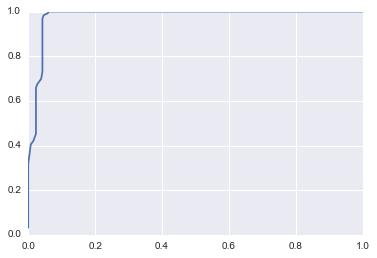

In [254]:
import matplotlib
%matplotlib inline
matplotlib.pyplot.plot(fpr,tpr)

In [262]:
sklearn.metrics.auc(fpr, tpr)

0.97991358705644416

# Model Evaluation

In [225]:
test = open('text.txt').read()


test_clean = re.sub("[^a-zA-Z]", " ", test)

stop = set(stopwords.words('english'))
stop.update([',', '"', "'", '?', '!', ':', ';', '(', ')', '[', ']', '{', '}', '...', 'Data', 'data', 'scientist', 'Scientist'])

test_word = [w for w in (nltk.word_tokenize(test_clean)) if w.lower() not in stop]


len(test_word)

103

In [227]:
array = []
for i in xrange(0,58):
    array.append(1)
for i in xrange(58,103):
    array.append(0)



In [228]:
DF = pd.DataFrame({'Sentences' : pd.Series(test_word),
                   "Fact" : array,
                   #'Probability' : list(zip(tfidf.get_feature_names(), logreg.coef_[0]))
                   })
DF["Y_pred"] = np.where(logreg.predict(tfidf.transform(test_word)), 1, 0)
DF

,Fact,Sentences,Y_pred
0,1,Investigate,1
1,1,problems,1
2,1,identify,1
3,1,patterns,1
4,1,passionate,0
5,1,applying,0
6,1,analytics,0
7,1,real,0
8,1,problems,1
9,1,seeking,0


In [229]:
((DF.Y_pred == 1) & (DF.Fact == 1)).sum()

40

In [230]:
((DF.Y_pred == 0) & (DF.Fact == 0)).sum()

27

In [231]:
conmat = np.array(confusion_matrix(DF.Y_pred, DF.Fact))
conmat

array([[27, 18],
       [18, 40]])

In [232]:
whole_df.junior.value_counts()

0    788
1    376
Name: junior, dtype: int64

In [263]:
(X_train, X_test, Y_train, Y_test) = train_test_split(
  tfidf.fit_transform(DF.Sentences),
  DF['Fact'],
  test_size=0.33
)

In [266]:
sklearn.cross_validation.cross_val_score(logreg,
                                         tfidf.fit_transform(DF.Sentences),
                                         DF.Y_pred,
                                         cv=10,
                                         scoring='accuracy')

array([ 0.54545455,  0.63636364,  0.63636364,  0.54545455,  0.54545455,
        0.6       ,  0.6       ,  0.6       ,  0.55555556,  0.55555556])